In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
from intrinsic_alignments.project_settings import PROJECT_DIRECTORY
%matplotlib inline

## TNG300 Model

In [2]:
# Load TNMG300 galaxy catalog

from Illustris_Shapes.simulation_props import sim_prop_dict

simname = 'TNG300-1'
snapnum = 99
shape_type = 'iterative'

d = sim_prop_dict[simname]
Lbox = d['Lbox']

In [3]:
from astropy.table import Table
fpath = PROJECT_DIRECTORY + 'data/Illustris/'

# load VAGC
fname = 'value_added_catalogs/' + simname + '_' + str(snapnum) + '_vagc.dat'
vagc_galaxy_table = Table.read(fpath + fname, format='ascii')

# load galaxy shape catalog
fname = 'shape_catalogs/' + simname + '_' + str(snapnum) + '_' + shape_type + '_galaxy_shapes.dat'
galaxy_shape_table = Table.read(fpath + fname, format='ascii')

# load halo shape catalog
fname = 'shape_catalogs/' + simname + '_' + str(snapnum) + '_' + shape_type + '_halo_shapes.dat'
halo_shape_table = Table.read(fpath + fname, format='ascii')

# join galaxy shape and vagc tables
from astropy.table import join
galaxy_table = join(vagc_galaxy_table, galaxy_shape_table)
for key in galaxy_table.keys():
    print(key)

gal_id
host_halo_id
central_id
x
y
z
vx
vy
vz
stellar_mass_in_twice_halfrad
stellar_mass_all
host_halo_mass_200m
host_halo_radius_200m
host_halo_fof_mass
a
b
c
av_x
av_y
av_z
bv_x
bv_y
bv_z
cv_x
cv_y
cv_z


In [4]:
# add halo properties
from halotools.utils import crossmatch
idx, idy = crossmatch(galaxy_table['gal_id'],halo_shape_table['halo_id'])

galaxy_table['halo_a'] = -1.0
galaxy_table['halo_b'] = -1.0
galaxy_table['halo_c'] = -1.0

galaxy_table['halo_a'][idx] = halo_shape_table['a'][idy]
galaxy_table['halo_b'][idx] = halo_shape_table['b'][idy]
galaxy_table['halo_c'][idx] = halo_shape_table['c'][idy]

galaxy_table['halo_av_x'] = -1.0
galaxy_table['halo_av_y'] = -1.0
galaxy_table['halo_av_z'] = -1.0

galaxy_table['halo_bv_x'] = -1.0
galaxy_table['halo_bv_y'] = -1.0
galaxy_table['halo_bv_z'] = -1.0

galaxy_table['halo_cv_x'] = -1.0
galaxy_table['halo_cv_y'] = -1.0
galaxy_table['halo_cv_z'] = -1.0

galaxy_table['halo_av_x'][idx] = halo_shape_table['av_x'][idy]
galaxy_table['halo_av_y'][idx] = halo_shape_table['av_y'][idy]
galaxy_table['halo_av_z'][idx] = halo_shape_table['av_z'][idy]

galaxy_table['halo_bv_x'][idx] = halo_shape_table['bv_x'][idy]
galaxy_table['halo_bv_y'][idx] = halo_shape_table['bv_y'][idy]
galaxy_table['halo_bv_z'][idx] = halo_shape_table['bv_z'][idy]

galaxy_table['halo_cv_x'][idx] = halo_shape_table['cv_x'][idy]
galaxy_table['halo_cv_y'][idx] = halo_shape_table['cv_y'][idy]
galaxy_table['halo_cv_z'][idx] = halo_shape_table['cv_z'][idy]

## calculate alignment strength

In [5]:
coords = np.vstack((galaxy_table['x'],
                    galaxy_table['y'],
                    galaxy_table['z'])).T/1000.0

# galaxy major_axis
gal_orientations_major = np.vstack((galaxy_table['av_x'],
                                galaxy_table['av_y'],
                                galaxy_table['av_z'])).T

# galaxy major_axis
gal_orientations_minor = np.vstack((galaxy_table['cv_x'],
                                galaxy_table['cv_y'],
                                galaxy_table['cv_z'])).T

# halo major_axis
halo_orientations_major = np.vstack((galaxy_table['halo_av_x'],
                                galaxy_table['halo_av_y'],
                                galaxy_table['halo_av_z'])).T

# halo major_axis
halo_orientations_minor = np.vstack((galaxy_table['halo_cv_x'],
                                galaxy_table['halo_cv_y'],
                                galaxy_table['halo_cv_z'])).T

In [6]:
selection_mask = galaxy_table['stellar_mass_all']>10**10.5
print('number of galaxies in selection: ', np.sum(selection_mask))

number of galaxies in selection:  24433


In [7]:
from intrinsic_alignments.ia_models.ia_model_components import inverse_alignment_strength

### central galxies

In [8]:
from rotations.vector_utilities import angles_between_list_of_vectors

centrals = (galaxy_table['gal_id']==galaxy_table['central_id'])

da = angles_between_list_of_vectors(gal_orientations_major, halo_orientations_major)
da = da[selection_mask & centrals]

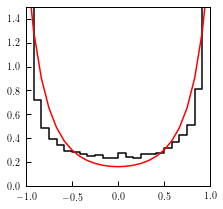

alignment strength:  [0.75504076]


In [9]:
# misalignment angle distribution
bins = np.linspace(-1,1,25)
cos_da = np.cos(da)
ran_u = np.random.random(len(cos_da))
mask = ran_u>0.5
cos_da[mask] = cos_da[mask]*-1.0
counts = np.histogram(cos_da, bins=bins)[0]
counts = 1.0*counts/np.sum(counts)/np.diff(bins)

# fit watson distribution
from watson_distribution import DimrothWatson
dist = DimrothWatson()
k = dist.fit(np.fabs(cos_da),floc=0, fscale=1)[0]

plt.figure(figsize=(3.3,3.3))
plt.step(bins[:-1], counts, color='black', where='post')
plt.plot(bins,dist.pdf(bins, k=k), color='red')
plt.xlim([-1,1])
plt.ylim([0,1.5])
plt.show()

print("alignment strength: ", inverse_alignment_strength(k))

### satellite galaxies

In [10]:
from halotools.utils import crossmatch
idx, idy = crossmatch(galaxy_table['central_id'], galaxy_table['gal_id'])

satellites = (galaxy_table['gal_id']!=galaxy_table['central_id'])

from intrinsic_alignments.utils.vector_utilities import pbc_radial_vector
r = pbc_radial_vector(coords[idx], coords[idy], Lbox=Lbox)
galaxy_table['r_x'] = np.zeros(len(galaxy_table)).astype('float')
galaxy_table['r_y'] = np.zeros(len(galaxy_table)).astype('float')
galaxy_table['r_z'] = np.zeros(len(galaxy_table)).astype('float')
galaxy_table['r_x'][idx] = r[:,0]
galaxy_table['r_y'][idx] = r[:,1]
galaxy_table['r_z'][idx] = r[:,2]
galaxy_table['mag_r'] = np.zeros(len(galaxy_table)).astype('float')
galaxy_table['mag_r'] = np.sqrt(galaxy_table['r_x']**2 + galaxy_table['r_y']**2 +galaxy_table['r_z']**2)

r = np.vstack((galaxy_table['r_x'], galaxy_table['r_y'], galaxy_table['r_z'])).T
da = angles_between_list_of_vectors(gal_orientations_major, r)
da = da[satellites & (~np.isnan(da)) & selection_mask]

/Users/duncan/Code/rotations/vector_utilities.py:145: RuntimeWarning: invalid value encountered in greater
  mask1 = (dot > 1) & (dot < 1 + tol)
/Users/duncan/Code/rotations/vector_utilities.py:145: RuntimeWarning: invalid value encountered in less
  mask1 = (dot > 1) & (dot < 1 + tol)
/Users/duncan/Code/rotations/vector_utilities.py:147: RuntimeWarning: invalid value encountered in less
  mask2 = (dot < -1) & (dot > -1 - tol)
/Users/duncan/Code/rotations/vector_utilities.py:147: RuntimeWarning: invalid value encountered in greater
  mask2 = (dot < -1) & (dot > -1 - tol)
/Users/duncan/Code/rotations/vector_utilities.py:149: RuntimeWarning: invalid value encountered in arccos
  a = np.arccos(dot)


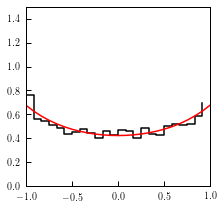

alignment strength:  [0.27935947]


In [11]:
# misalignment angle distribution
bins = np.linspace(-1,1,25)
cos_da = np.cos(da)
ran_u = np.random.random(len(cos_da))
mask = ran_u>0.5
cos_da[mask] = cos_da[mask]*-1.0
counts = np.histogram(cos_da, bins=bins)[0]
counts = 1.0*counts/np.sum(counts)/np.diff(bins)

# fit watson distribution
from watson_distribution import DimrothWatson
dist = DimrothWatson()
k = dist.fit(np.fabs(cos_da),floc=0, fscale=1)[0]

plt.figure(figsize=(3.3,3.3))
plt.step(bins[:-1], counts, color='black', where='post')
plt.plot(bins,dist.pdf(bins, k=k), color='red')
plt.xlim([-1,1])
plt.ylim([0,1.5])
plt.show()

print("alignment strength: ", inverse_alignment_strength(k))

In [12]:
from intrinsic_alignments.utils.stat_utils import binned_bootstrap_1d

Nboot = 2

# check for radial dependence 
rbins = np.logspace(-1.,0.0,15)
rbin_centers = (rbins[:-1]+rbins[1:])/2.0

scaled_radius = (galaxy_table['mag_r'])/(galaxy_table['host_halo_radius_200m']/1000)
scaled_radius = scaled_radius[selection_mask & satellites]

statisic = lambda x: inverse_alignment_strength(dist.fit(x, floc=0, fscale=1)[0])
p, err_p = binned_bootstrap_1d(scaled_radius, cos_da, rbins,
                               statistic=statisic, Nboot=Nboot)

/Users/duncan/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:2313: RuntimeWarning: Mean of empty slice.
  muhat = tmp.mean()
/Users/duncan/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/duncan/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:2314: RuntimeWarning: Degrees of freedom <= 0 for slice
  mu2hat = tmp.var()
/Users/duncan/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/duncan/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


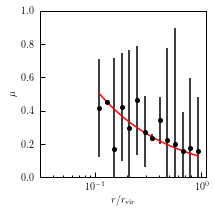

In [13]:
def clipped_powerlaw(x, x0=0.01, alpha=-0.05):
    """
    clipped power law model
    """
    ymax=1.0
    ymin=-1.0
    x = np.atleast_1d(x)
    
    result = np.zeros(len(x))
    result = (x/x0)**alpha
    
    mask = (result>ymax)
    result[mask] = ymax
    mask = (result<ymin)
    result[mask] = ymin
    
    return result

from scipy.optimize import curve_fit

popt, pcov = curve_fit(clipped_powerlaw, rbin_centers, p, sigma=err_p, p0=[0.01, -0.05])

fig, ax = plt.subplots(1,1,figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
ax.errorbar(rbin_centers, p, yerr=5*err_p, fmt='o', ms=4, color='black')
ax.plot(rbin_centers, clipped_powerlaw(rbin_centers, *popt), '-', color='red')
ax.set_ylim([0,1])
ax.set_xscale('log')
ax.set_xlim(0.03,1.1)
ax.set_xlabel(r'$r/r_{\rm vir}$')
ax.set_ylabel(r'$\mu$')
plt.show()

## Measure observables

In [14]:
rbins = np.logspace(-1,1.5,15)
rbin_centers = (rbins[:-1]+rbins[1:])/2.0

In [15]:
from intrinsic_alignments.utils.jackknife_observables import jackknife_ed_3d, jackknife_ee_3d

result_1, cov_1 = jackknife_ee_3d(coords[selection_mask], gal_orientations_major[selection_mask],
                                  coords[selection_mask], gal_orientations_major[selection_mask],
                                  rbins, period=Lbox,
                                  Nsub=[4, 4, 4], verbose=True)
result_1_err = np.sqrt(np.diag(cov_1))

result_2, cov_2 = jackknife_ed_3d(coords[selection_mask], gal_orientations_major[selection_mask],
                                  coords[selection_mask],
                                  rbins, period=Lbox,
                                  Nsub=[4, 4, 4], verbose=True)
result_2_err = np.sqrt(np.diag(cov_2))

estimated time to complete jackknife calculation (s): 46.9998779297
estimated time to complete jackknife calculation (s): 58.8820495605


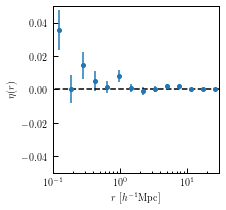

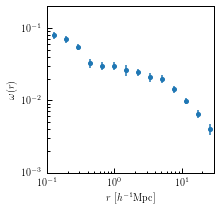

In [16]:
fig, ax = plt.subplots(1,1, sharex=False, sharey=False, figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
ax.errorbar(rbin_centers, result_1, result_1_err, fmt='o', ms=4)
ax.plot([0.001,100],[0,0], '--', color='black')
ax.set_xscale('log')
ax.set_ylim([-0.05,0.05])
ax.set_xlim([0.1,30])
ax.set_ylabel(r'$\eta(r)$')
ax.set_xlabel(r'$r~[h^{-1}{\rm Mpc}]$')
plt.show()

fig, ax = plt.subplots(1,1, sharex=False, sharey=False, figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
ax.errorbar(rbin_centers, result_2, result_2_err, fmt='o', ms=4)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([0.001,0.2])
ax.set_xlim([0.1,30])
ax.set_ylabel(r'$\omega(r)$')
ax.set_xlabel(r'$r~[h^{-1}{\rm Mpc}]$')
plt.show()


## halo model

In [56]:
# load a test halo catalog

from halotools.sim_manager import CachedHaloCatalog
halocat = CachedHaloCatalog(simname='bolplanck', halo_finder='rockstar',
                            redshift=0.0, dz_tol=0.1, version_name='halotools_v0p4')

#halocat = CachedHaloCatalog(simname='smdpl_400', halo_finder='Rockstar',
#                            redshift=0.0, dz_tol=0.1, version_name='custom')

#halocat = CachedHaloCatalog(simname='mdpl2_1000', halo_finder='Rockstar',
#                            redshift=0.0, dz_tol=0.1, version_name='custom')

# add estimate of minor axis
from rotations.vector_utilities import normalized_vectors
B = np.vstack((halocat.halo_table['halo_axisA_x'],
               halocat.halo_table['halo_axisA_y'],
               halocat.halo_table['halo_axisA_z'])).T
A = np.vstack((halocat.halo_table['halo_jx'],
               halocat.halo_table['halo_jy'],
               halocat.halo_table['halo_jz'])).T
B = normalized_vectors(B)
A = normalized_vectors(A)

D = np.cross(A, B)
C = np.cross(B, D)

halocat.halo_table['halo_axisC_x'] = C[:,0]
halocat.halo_table['halo_axisC_y'] = C[:,1]
halocat.halo_table['halo_axisC_z'] = C[:,2]

In [18]:
halocat.halo_table

halo_upid,halo_b_to_a,halo_axisA_x,halo_axisA_y,halo_y,halo_vacc,halo_pid,halo_x,halo_z,halo_m200b,halo_m200c,halo_c_to_a,halo_acc_scale,halo_rvir,halo_vpeak,halo_axisA_z,halo_mpeak_scale,halo_vmax,halo_mpeak,halo_macc,halo_vmax_at_mpeak,halo_id,halo_first_acc_scale,halo_vx,halo_vy,halo_vz,halo_jx,halo_jy,halo_jz,halo_rs,halo_half_mass_scale,halo_mvir,halo_nfw_conc,halo_hostid,halo_mvir_host_halo,halo_axisC_x,halo_axisC_y,halo_axisC_z
int64,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32
-1,0.68498,45.6166,18.7846,17.93721,794.61,-1,13.78148,15.99919,129810000000000.0,96138000000000.0,0.61681,1.0,0.985232,884.21,10.1838,0.8324,794.61,116680000000000.0,113520000000000.0,790.27,11994464703,1.0,-66.62,156.22,-166.2,624900000000000.0,799100000000000.0,3056000000000000.0,0.142735,0.442,113520000000000.0,6.9025254,11994464703,113520000000000.0,-0.222642,0.07657092,0.8560476
-1,0.72217,12.2561,-18.4853,18.68475,688.61,-1,10.20494,14.45674,105910000000000.0,73603000000000.0,0.57063,1.0,0.91784,792.31,36.468,1.0,688.61,91783000000000.0,91783000000000.0,688.61,11994466051,1.0,230.68,376.37,-171.26,655600000000000.0,1451000000000000.0,3874000000000000.0,0.181766,0.6104,91783000000000.0,5.049569,11994466051,91783000000000.0,-0.040213533,0.64316183,0.33952785
-1,0.78226,-7.65737,36.6105,37.99561,573.08,-1,0.42518,3.04904,54866000000000.0,36684000000000.0,0.64501,1.0,0.715539,622.33,6.69149,1.0,573.08,43487000000000.0,43487000000000.0,573.08,11994880314,1.0,-39.33,673.76,-419.49,194200000000000.0,-603300000000000.0,164000000000000.0,0.105363995,0.5684,43487000000000.0,6.791115,11994880314,43487000000000.0,0.11454292,-0.050914705,0.40964124
-1,0.42231,-23.1869,-15.5698,2.5109,607.75,-1,27.19982,25.23063,44030000000000.0,37263000000000.0,0.31774,1.0,0.706323,610.64,41.5877,1.0,607.75,41829000000000.0,41829000000000.0,607.75,11994490119,1.0,114.18,171.64,73.89,-1386000000000000.0,884500000000000.0,-706900000000000.0,0.089035004,0.8984,41829000000000.0,7.9330935,11994490119,41829000000000.0,-0.8313858,0.4559696,-0.29282466
-1,0.62796,-13.4031,34.3081,27.62044,546.45,-1,5.07394,10.82814,43574000000000.0,30755000000000.0,0.54901,1.0,0.688006,574.02,5.20395,0.8414,546.45,39404000000000.0,38658000000000.0,549.67,11994879649,1.0,13.54,133.22,-193.09,699900000000000.0,299700000000000.0,-800000000000000.0,0.107521005,0.53,38658000000000.0,6.398805,11994879649,38658000000000.0,0.6051351,0.34459868,-0.71327364
-1,0.76123,-13.2959,-14.0463,24.66384,557.57,-1,3.58714,3.85697,38944000000000.0,31768000000000.0,0.70509,1.0,0.673361,606.67,25.5757,1.0,557.57,36242000000000.0,36242000000000.0,557.57,11994466467,1.0,145.54,340.09,-16.57,221300000000000.0,-615300000000000.0,-132000000000000.0,0.080086,0.442,36242000000000.0,8.407974,11994466467,36242000000000.0,0.37680262,-0.87478256,-0.28454852
-1,0.44829,-16.4834,56.2679,30.83088,539.99,-1,0.65961,0.40194,37169000000000.0,31388000000000.0,0.30543,1.0,0.66177505,606.83,5.70815,1.0,539.99,34403000000000.0,34403000000000.0,539.99,11994880625,1.0,11.69,376.94,-40.94,721500000000000.0,339800000000000.0,-176000000000000.0,0.105984,0.8324,34403000000000.0,6.2441034,11994880625,34403000000000.0,0.9196194,0.2925309,-0.22803275
-1,0.72503,27.3942,15.4348,11.37242,496.43,-1,13.5985,22.15908,35469000000000.0,26319000000000.0,0.68713,1.0,0.646026,551.59,1.92807,1.0,496.43,32005000000000.0,32005000000000.0,496.43,11994491119,1.0,118.45,73.11,-351.11,350300000000000.0,-691800000000000.0,314400000000000.0,0.124532,0.6643,32005000000000.0,5.1876307,11994491119,32005000000000.0,0.43432942,-0.81793684,0.37684494
-1,0.78082,18.1928,20.0522,16.34173,505.9,-1,7.56382,11.56551,27456000000000.0,21298000000000.0,0.63042,1.0,0.59859496,513.99,9.79576,1.0,505.9,25460000000000.0,25460000000000.0,505.

In [44]:
from halotools.empirical_models import HodModelFactory

# define the central occupatoion model
from halotools.empirical_models import TrivialPhaseSpace, Zheng07Cens
cens_occ_model =  Zheng07Cens(prim_haloprop_key='halo_m200b')
cens_prof_model = TrivialPhaseSpace()

# define the satellite occupation model
from halotools.empirical_models import Zheng07Sats
from halotools.empirical_models import NFWPhaseSpace, SubhaloPhaseSpace
from intrinsic_alignments.ia_models.anisotropic_nfw_phase_space import AnisotropicNFWPhaseSpace
sats_occ_model =  Zheng07Sats(prim_haloprop_key='halo_m200b')
#sats_prof_model = AnisotropicNFWPhaseSpace(anisotropy_bias=1.1)
#sats_prof_model = NFWPhaseSpace()
sats_prof_model = SubhaloPhaseSpace('satellites', np.logspace(10.4, 15.5, 15))

# define the alignment models
from intrinsic_alignments.ia_models.ia_model_components import CentralAlignment,\
    RadialSatelliteAlignment,  MajorAxisSatelliteAlignment, HybridSatelliteAlignment
central_orientation_model = CentralAlignment()
satellite_orientation_model = RadialSatelliteAlignment()

In [45]:
# 10.5
cens_occ_model.param_dict['logMmin'] = 12.54
cens_occ_model.param_dict['sigma_logM'] = 0.26

sats_occ_model.param_dict['alpha'] = 1.0
sats_occ_model.param_dict['logM0'] = 12.68
sats_occ_model.param_dict['logM1'] = 13.48

central_orientation_model.param_dict['central_alignment_strength'] = 0.755
satellite_orientation_model.param_dict['satellite_alignment_strength'] = 0.279

In [22]:
# 10.0
cens_occ_model.param_dict['logMmin'] = 11.93
cens_occ_model.param_dict['sigma_logM'] = 0.26

sats_occ_model.param_dict['alpha'] = 1.0
sats_occ_model.param_dict['logM0'] = 12.05
sats_occ_model.param_dict['logM1'] = 12.85

central_orientation_model.param_dict['central_alignment_strength'] = 0.64
satellite_orientation_model.param_dict['satellite_alignment_strength'] = 0.084

In [23]:
# 9.5
cens_occ_model.param_dict['logMmin'] = 11.61
cens_occ_model.param_dict['sigma_logM'] = 0.26

sats_occ_model.param_dict['alpha'] = 1.0
sats_occ_model.param_dict['logM0'] = 11.8
sats_occ_model.param_dict['logM1'] = 12.6

central_orientation_model.param_dict['central_alignment_strength'] = 0.57172919
satellite_orientation_model.param_dict['satellite_alignment_strength'] = 0.01995

In [46]:
# combine model components
model_instance = HodModelFactory(centrals_occupation = cens_occ_model,
                                 centrals_profile = cens_prof_model,
                                 satellites_occupation = sats_occ_model,
                                 satellites_profile = sats_prof_model,
                                 centrals_orientation = central_orientation_model,
                                 satellites_orientation = satellite_orientation_model,
                                 model_feature_calling_sequence = (
                                 'centrals_occupation',
                                 'centrals_profile',
                                 'satellites_occupation',
                                 'satellites_profile',
                                 'centrals_orientation',
                                 'satellites_orientation')
                                )

In [57]:
# populate mock catalog
model_instance.populate_mock(halocat)
print("number of galaxies: ", len(model_instance.mock.galaxy_table))

mock = model_instance.mock.galaxy_table

number of galaxies:  33139


## observables

In [58]:
# galaxy coordinates and orientations
galaxy_coords = np.vstack((mock['x'],
                           mock['y'],
                           mock['z'])).T

galaxy_orientations = np.vstack((mock['galaxy_axisA_x'],
                                 mock['galaxy_axisA_y'],
                                 mock['galaxy_axisA_z'])).T

In [59]:
from halotools.mock_observables import tpcf, tpcf_jackknife

rbins = np.logspace(-1,1.5,15)
rbin_centers = (rbins[:-1]+rbins[1:])/2.0

xi_mock = tpcf(galaxy_coords, rbins, period=halocat.Lbox)

In [60]:
xi_tng = tpcf(coords[selection_mask], rbins, period=Lbox)
xi_tng_err = xi_tng * 0.0

In [61]:
N=10**5
randoms = np.random.random((N,3))*halocat.Lbox
#xi_tng, xi_tng_cov = tpcf_jackknife(coords[selection_mask], randoms, rbins, period=Lbox, Nsub=[2, 2, 2])
#xi_tng_err = np.sqrt(np.diag(xi_tng_cov))

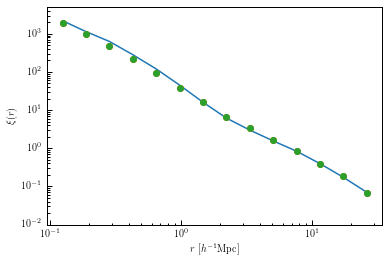

In [62]:
plt.figure()
plt.plot(rbin_centers, xi_mock)
plt.plot(rbin_centers, xi_tng, 'o')
plt.errorbar(rbin_centers, xi_tng, yerr=xi_tng_err, fmt= 'o')
plt.xscale('log')
plt.yscale('log')
plt.ylim([0.01,5000])
plt.ylabel(r'$\xi(r)$')
plt.xlabel(r'$r ~[h^{-1}{\rm Mpc}]$')
plt.show()

In [63]:
from halotools.mock_observables.alignments import ed_3d, ee_3d

result_11 = ee_3d(galaxy_coords, galaxy_orientations,
                  galaxy_coords, galaxy_orientations,
                  rbins, period=halocat.Lbox)

result_22 = ed_3d(galaxy_coords, galaxy_orientations,
                  galaxy_coords,
                  rbins, period=halocat.Lbox)

In [64]:
result_11_a = np.copy(result_11)
result_22_a = np.copy(result_22)

In [148]:
result_11_b = np.copy(result_11)
result_22_b = np.copy(result_22)

In [149]:
result_11_c = np.copy(result_11)
result_22_c = np.copy(result_22)

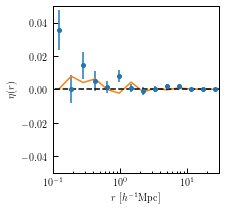

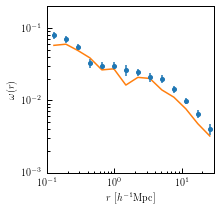

In [65]:
fig, ax = plt.subplots(1,1, sharex=False, sharey=False, figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
ax.errorbar(rbin_centers, result_1, result_1_err, fmt='o', ms=4)
ax.plot(rbin_centers, result_11_a, '-')
#ax.plot(rbin_centers, result_11_b, ':')
#ax.plot(rbin_centers, result_11_c, '-.')
ax.plot([0.001,100],[0,0], '--', color='black')
ax.set_xscale('log')
ax.set_ylim([-0.05,0.05])
ax.set_xlim([0.1,30])
ax.set_ylabel(r'$\eta(r)$')
ax.set_xlabel(r'$r~[h^{-1}{\rm Mpc}]$')
plt.show()

fname = 'ee_comp_10.5.pdf'
fig.savefig('/Users/duncan/Desktop/'+fname, dpi=250)

fig, ax = plt.subplots(1,1, sharex=False, sharey=False, figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
ax.errorbar(rbin_centers, result_2, result_2_err, fmt='o', ms=4)
l1, = ax.plot(rbin_centers, result_22_a, '-')
#l2, = ax.plot(rbin_centers, result_22_b, ':')
#l3, = ax.plot(rbin_centers, result_22_c, '-.')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([0.001,0.2])
ax.set_xlim([0.1,30])
ax.set_ylabel(r'$\omega(r)$')
ax.set_xlabel(r'$r~[h^{-1}{\rm Mpc}]$')
#ax.legend([l1,l2,l3],['triaxial NFW','NFW','SubhaloPhaseSpace'], loc='lower left', frameon=False, fontsize=10)
plt.show()

fname = 'ed_comp_10.5.pdf'
fig.savefig('/Users/duncan/Desktop/'+fname, dpi=250)

In [143]:
result_2_err/result_2

array([0.11029405, 0.1067032 , 0.10086693, 0.14298655, 0.12048577,
       0.13346409, 0.16711355, 0.11841315, 0.13375961, 0.12481284,
       0.10430888, 0.10100801, 0.12723026, 0.17812767])

In [151]:
from halotools.mock_observables.alignments import ee_3d_one_two_halo_decomp, ed_3d_one_two_halo_decomp

centrals = (mock['gal_type']=='centrals')
satellites = (mock['gal_type']=='satellites')
host_ids = mock['halo_hostid']

In [152]:
mock_eta_1h_ss, mock_eta_2h_ss = ed_3d_one_two_halo_decomp(galaxy_coords, galaxy_orientations,
                                    host_ids,
                                    galaxy_coords, host_ids,
                                    rbins,
                                    mask1 = satellites,  
                                    mask2 = satellites,
                                    period=halocat.Lbox, num_threads=4)

In [153]:
mock_eta_1h_cs, mock_eta_2h_cs = ed_3d_one_two_halo_decomp(galaxy_coords, galaxy_orientations,
                                    host_ids,
                                    galaxy_coords, host_ids,
                                    rbins,
                                    mask1 = centrals,  
                                    mask2 = satellites,
                                    period=halocat.Lbox, num_threads=4)

In [154]:
mock_eta_1h_sc, mock_eta_2h_sc = ed_3d_one_two_halo_decomp(galaxy_coords, galaxy_orientations,
                                    host_ids,
                                    galaxy_coords, host_ids,
                                    rbins,
                                    mask1 = satellites,  
                                    mask2 = centrals,
                                    period=halocat.Lbox, num_threads=4)

In [155]:
mock_eta_1h_cc, mock_eta_2h_cc = ed_3d_one_two_halo_decomp(galaxy_coords, galaxy_orientations,
                                    host_ids,
                                    galaxy_coords, host_ids,
                                    rbins,
                                    mask1 = centrals,  
                                    mask2 = centrals,
                                    period=halocat.Lbox, num_threads=4)

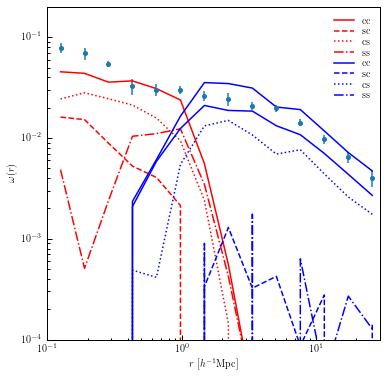

In [156]:
# plot ED results

mock_one_halo = mock_eta_1h_cc + mock_eta_1h_sc + mock_eta_1h_cs + mock_eta_1h_ss
mock_two_halo = mock_eta_2h_cc + mock_eta_2h_sc + mock_eta_2h_cs + mock_eta_2h_ss

fig, ax = plt.subplots(figsize=(6.6,6.6))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
ax.errorbar(rbin_centers, result_2, result_2_err, fmt='o', ms=4)
plt.plot(rbin_centers, mock_one_halo, '-', color='red')
l4, = plt.plot(rbin_centers, mock_eta_1h_cc, '-', color='red')
l5, = plt.plot(rbin_centers, mock_eta_1h_sc, '--', color='red')
l6, = plt.plot(rbin_centers, mock_eta_1h_cs, ':', color='red')
l7, = plt.plot(rbin_centers, mock_eta_1h_ss, '-.', color='red')
plt.plot(rbin_centers, mock_two_halo, '-', color='blue')
l8, = plt.plot(rbin_centers, mock_eta_2h_cc, '-', color='blue')
l9, = plt.plot(rbin_centers, mock_eta_2h_sc, '--', color='blue')
l10, = plt.plot(rbin_centers, mock_eta_2h_cs, ':', color='blue')
l11, = plt.plot(rbin_centers, mock_eta_2h_ss, '-.', color='blue')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([0.0001,0.2])
ax.set_xlim([0.1,30])
ax.set_ylabel(r'$\omega(r)$')
ax.set_xlabel(r'$r~[h^{-1}{\rm Mpc}]$')
plt.legend([l4,l5,l6, l7, l8, l9, l10, l11],['cc', 'sc', 'cs', 'ss', 'cc', 'sc', 'cs', 'ss'],
           frameon=False, loc='upper right', fontsize=10, labelspacing=0.1)
plt.show()

In [157]:
centrals = (galaxy_table['gal_id']==galaxy_table['central_id'])
satellites = (galaxy_table['gal_id']!=galaxy_table['central_id'])
host_ids = galaxy_table['central_id']

In [158]:
tng_eta_1h_ss, tng_eta_2h_ss = ed_3d_one_two_halo_decomp(coords[selection_mask], gal_orientations_major[selection_mask],
                                    host_ids[selection_mask],
                                    coords[selection_mask], host_ids[selection_mask],
                                    rbins,
                                    mask1 = satellites[selection_mask],  
                                    mask2 = satellites[selection_mask],
                                    period=halocat.Lbox, num_threads=4)

In [159]:
tng_eta_1h_cs, tng_eta_2h_cs = ed_3d_one_two_halo_decomp(coords[selection_mask], gal_orientations_major[selection_mask],
                                    host_ids[selection_mask],
                                    coords[selection_mask], host_ids[selection_mask],
                                    rbins,
                                    mask1 = centrals[selection_mask],  
                                    mask2 = satellites[selection_mask],
                                    period=halocat.Lbox, num_threads=4)

In [160]:
tng_eta_1h_sc, tng_eta_2h_sc = ed_3d_one_two_halo_decomp(coords[selection_mask], gal_orientations_major[selection_mask],
                                    host_ids[selection_mask],
                                    coords[selection_mask], host_ids[selection_mask],
                                    rbins,
                                    mask1 = satellites[selection_mask],  
                                    mask2 = centrals[selection_mask],
                                    period=halocat.Lbox, num_threads=4)

In [161]:
tng_eta_1h_cc, tng_eta_2h_cc = ed_3d_one_two_halo_decomp(coords[selection_mask], gal_orientations_major[selection_mask],
                                    host_ids[selection_mask],
                                    coords[selection_mask], host_ids[selection_mask],
                                    rbins,
                                    mask1 = centrals[selection_mask],  
                                    mask2 = centrals[selection_mask],
                                    period=halocat.Lbox, num_threads=4)

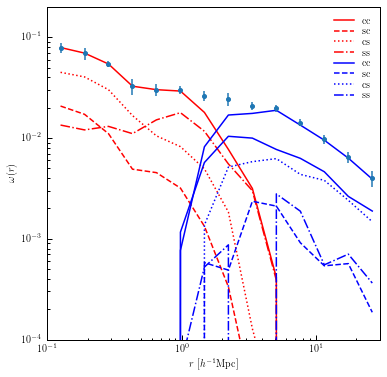

In [162]:
# plot ED results

tng_one_halo = tng_eta_1h_cc + tng_eta_1h_sc + tng_eta_1h_cs + tng_eta_1h_ss
tng_two_halo = tng_eta_2h_cc + tng_eta_2h_sc + tng_eta_2h_cs + tng_eta_2h_ss




fig, ax = plt.subplots(figsize=(6.6,6.6))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
ax.errorbar(rbin_centers, result_2, result_2_err, fmt='o', ms=4)
plt.plot(rbin_centers, tng_one_halo, '-', color='red')
l4, = plt.plot(rbin_centers, tng_eta_1h_cc, '-', color='red')
l5, = plt.plot(rbin_centers, tng_eta_1h_sc, '--', color='red')
l6, = plt.plot(rbin_centers, tng_eta_1h_cs, ':', color='red')
l7, = plt.plot(rbin_centers, tng_eta_1h_ss, '-.', color='red')
plt.plot(rbin_centers, tng_two_halo, '-', color='blue')
l8, = plt.plot(rbin_centers, tng_eta_2h_cc, '-', color='blue')
l9, = plt.plot(rbin_centers, tng_eta_2h_sc, '--', color='blue')
l10, = plt.plot(rbin_centers, tng_eta_2h_cs, ':', color='blue')
l11, = plt.plot(rbin_centers, tng_eta_2h_ss, '-.', color='blue')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([0.0001,0.2])
ax.set_xlim([0.1,30])
ax.set_ylabel(r'$\omega(r)$')
ax.set_xlabel(r'$r~[h^{-1}{\rm Mpc}]$')
plt.legend([l4,l5,l6, l7, l8, l9, l10, l11],['cc', 'sc', 'cs', 'ss', 'cc', 'sc', 'cs', 'ss'],
           frameon=False, loc='upper right', fontsize=10, labelspacing=0.1)
plt.show()

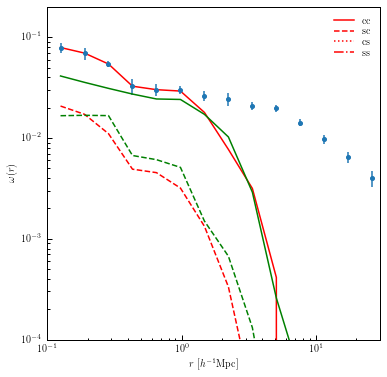

In [184]:
fig, ax = plt.subplots(figsize=(6.6,6.6))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
ax.errorbar(rbin_centers, result_2, result_2_err, fmt='o', ms=4)
plt.plot(rbin_centers, tng_one_halo, '-', color='red')
l5, = plt.plot(rbin_centers, tng_eta_1h_sc, '--', color='red')
plt.plot(rbin_centers, mock_one_halo, '-', color='green')
plt.plot(rbin_centers, mock_eta_1h_sc, '--', color='green')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([0.0001,0.2])
ax.set_xlim([0.1,30])
ax.set_ylabel(r'$\omega(r)$')
ax.set_xlabel(r'$r~[h^{-1}{\rm Mpc}]$')
plt.legend([l4,l5,l6, l7],['cc', 'sc', 'cs', 'ss'],
           frameon=False, loc='upper right', fontsize=10, labelspacing=0.1)
plt.show()

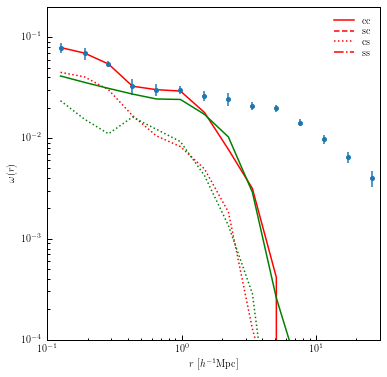

In [185]:
fig, ax = plt.subplots(figsize=(6.6,6.6))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
ax.errorbar(rbin_centers, result_2, result_2_err, fmt='o', ms=4)
plt.plot(rbin_centers, tng_one_halo, '-', color='red')
l6, = plt.plot(rbin_centers, tng_eta_1h_cs, ':', color='red')
plt.plot(rbin_centers, mock_one_halo, '-', color='green')
plt.plot(rbin_centers, mock_eta_1h_cs, ':', color='green')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([0.0001,0.2])
ax.set_xlim([0.1,30])
ax.set_ylabel(r'$\omega(r)$')
ax.set_xlabel(r'$r~[h^{-1}{\rm Mpc}]$')
plt.legend([l4,l5,l6, l7],['cc', 'sc', 'cs', 'ss'],
           frameon=False, loc='upper right', fontsize=10, labelspacing=0.1)
plt.show()

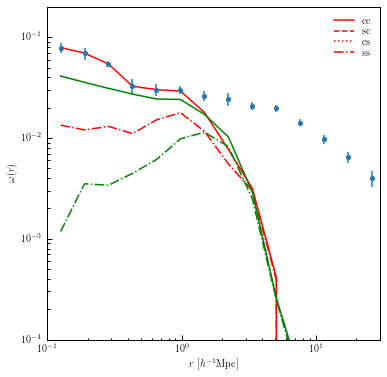

In [186]:
fig, ax = plt.subplots(figsize=(6.6,6.6))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
ax.errorbar(rbin_centers, result_2, result_2_err, fmt='o', ms=4)
plt.plot(rbin_centers, tng_one_halo, '-', color='red')
l7, = plt.plot(rbin_centers, tng_eta_1h_ss, '-.', color='red')
plt.plot(rbin_centers, mock_one_halo, '-', color='green')
plt.plot(rbin_centers, mock_eta_1h_ss, '-.', color='green')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([0.0001,0.2])
ax.set_xlim([0.1,30])
ax.set_ylabel(r'$\omega(r)$')
ax.set_xlabel(r'$r~[h^{-1}{\rm Mpc}]$')
plt.legend([l4,l5,l6, l7],['cc', 'sc', 'cs', 'ss'],
           frameon=False, loc='upper right', fontsize=10, labelspacing=0.1)
plt.show()